In [295]:
import copy
import geopandas as gpd
from shapely.geometry import Point

In [2]:
INPUT_FILE = "Data/BedrockP.shp"
bd = gpd.read_file(INPUT_FILE)
bd.head()

,gid,upid,area_m2,strat_unit,era,period,strat_age,strat_name,gp_suite,fm_lithodm,...,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org,geometry
0,33649.0,9c192ffb,4368828.0,uKPCvl,Mesozoic,Cretaceous,Upper Cretaceous,Powell Creek Formation - upper unit,None,Powell Creek Formation,...,Overlap,None,None,Chilcotin-Bonaparte,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza et al., 1997, Chilcotin-Bonaparte, ...","Schiarizza, 2017, Chicotin-Bonaparte",2018-04-05,British Columbia Geological Survey,"POLYGON ((466212.803 5669781.240, 466385.735 5..."
1,26344.0,824df15e,34431394.0,lKGsv,Mesozoic,Cretaceous,Lower Cretaceous,Gambier Group,Gambier Group,None,...,Overlap,None,None,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((541326.012 5529535.059, 541118.840 5..."
2,29100.0,2f4fa4a6,74490974.0,lKGsv,Mesozoic,Cretaceous,Lower Cretaceous,Gambier Group,Gambier Group,None,...,Overlap,None,None,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((541118.840 5528958.183, 541326.012 5..."
3,18121.0,8c3e4237,28858519.0,JKCsf,Mesozoic,Jurassic to Cretaceous,Jurassic to Cretaceous,Cayoosh assemblage?,Cayoosh assemblage?,None,...,Bridge River,None,None,Okanagan,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza and Church., 1996, Okanagan, BCGS, ...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((508143.471 5601807.482, 508301.595 5..."
4,18113.0,d7681ec3,38898103.0,Mivb,Cenozoic,Neogene,Miocene,None,None,None,...,Younger Volcanics,None,None,Okanagan,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza and Church., 1996, Okanagan, BCGS, ...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((508835.893 5603890.448, 508674.020 5..."


In [31]:
bd['rock_type'].head(30)

0     coarse volcaniclastic and pyroclastic volcanic...
1                 marine sedimentary and volcanic rocks
2                 marine sedimentary and volcanic rocks
3     mudstone, siltstone, shale fine clastic sedime...
4                               basaltic volcanic rocks
5                           undivided sedimentary rocks
6                           undivided sedimentary rocks
7                              andesitic volcanic rocks
8                           undivided sedimentary rocks
9                  feldspar porphyritic intrusive rocks
10                          undivided sedimentary rocks
11                          undivided sedimentary rocks
12                marine sedimentary and volcanic rocks
13                          undivided sedimentary rocks
14                        granodioritic intrusive rocks
15                        granodioritic intrusive rocks
16                marine sedimentary and volcanic rocks
17                                     ultramafi

In [3]:
geo = bd['geometry']
geo

0       POLYGON ((466212.803 5669781.240, 466385.735 5...
1       POLYGON ((541326.012 5529535.059, 541118.840 5...
2       POLYGON ((541118.840 5528958.183, 541326.012 5...
3       POLYGON ((508143.471 5601807.482, 508301.595 5...
4       POLYGON ((508835.893 5603890.448, 508674.020 5...
                              ...                        
1591    POLYGON ((476082.704 5549727.241, 475761.952 5...
1592    POLYGON ((496613.988 5534771.006, 496315.971 5...
1593    POLYGON ((460878.646 5599077.963, 460582.999 5...
1594    POLYGON ((640998.944 5566736.997, 641981.448 5...
1595    POLYGON ((660728.221 5528947.003, 660543.375 5...
Name: geometry, Length: 1596, dtype: geometry

[(466385.7352393744, 5669946.431659935)]
[(466212.8026486822, 5669781.23969778)]
[(466385.7352393744, 5669946.431659935)]


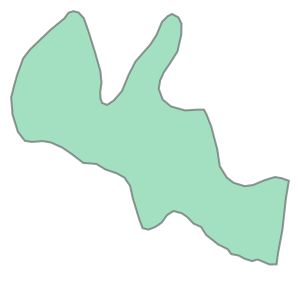

In [44]:
poly1 = geo[0]
poly2 = geo[1]
poly1.distance(poly2)
a = Point(poly1.exterior.coords[1])
b = Point(poly1.exterior.coords[-1])
print(list(a.coords))
print(list(b.coords))
c = a - b
print(list(c.coords))

poly1

# Heatmaps from polygon proximity

To build a heatmap, we need a set of Points. 
We are given a set of Polygons, which have a set of exterior coordinates, which are Points. 
The points we are interested in are places where one type of Polygon, A, is close to another type of Polygon, B, within some range. 
We will assume that none of the Polygons are overlapping. 

## How to solve the problem
We need two new datasets: 
1. The list of exterior coordinates from type A polygons
2. The list of exterior coordinates from type B polygons

Then, we find the set of A and B point pairs that are less than some distance N apart. 

We calculate the midpoint between every A point and every B point, and we plot the midpoints in a heatmap. 

### Step 1: Get all Type A rocks

In [124]:
typeARocksData = bd[bd['rock_type'].str.contains('serpentinite') | bd['rock_type'].str.contains('ultramafic')].loc[:, ['rock_type', 'geometry']]
typeARocksData = typeARocksData.loc[:, ['rock_type', 'geometry']]
typeARocksData.head()

,rock_type,geometry
17,ultramafic rocks,"POLYGON ((550887.442 5638245.333, 550753.877 5..."
24,serpentinite ultramafic rocks,"POLYGON ((531424.135 5613962.183, 531692.767 5..."
39,serpentinite ultramafic rocks,"POLYGON ((530406.930 5614886.454, 530408.769 5..."
50,ultramafic rocks,"POLYGON ((544869.648 5596786.572, 544066.961 5..."
60,serpentinite ultramafic rocks,"POLYGON ((517670.470 5618847.114, 517516.725 5..."


### Step 2: Get all Type B rocks

In [125]:
typeBRocksData = bd[bd['rock_type'].str.contains('granodioritic')].loc[:, ['rock_type', 'geometry']]
typeBRocksData = typeBRocksData.loc[:, ['rock_type', 'geometry']]
typeBRocksData.head()

,rock_type,geometry
14,granodioritic intrusive rocks,"POLYGON ((546785.936 5634543.225, 546791.903 5..."
15,granodioritic intrusive rocks,"POLYGON ((551602.263 5626737.312, 551566.932 5..."
29,granodioritic intrusive rocks,"POLYGON ((591984.930 5592990.168, 591314.087 5..."
30,granodioritic intrusive rocks,"POLYGON ((633896.330 5601738.072, 634218.739 5..."
31,granodioritic intrusive rocks,"POLYGON ((634533.242 5601280.707, 634218.739 5..."


### Step 3: Get all Type A points

In [150]:
typeARocksData['geometry'].exterior

17      LINEARRING (550887.442 5638245.333, 550753.877...
24      LINEARRING (531424.135 5613962.183, 531692.767...
39      LINEARRING (530406.930 5614886.454, 530408.769...
50      LINEARRING (544869.648 5596786.572, 544066.961...
60      LINEARRING (517670.470 5618847.114, 517516.725...
                              ...                        
1302    LINEARRING (572117.834 5715942.571, 572095.708...
1332    LINEARRING (556490.969 5579696.825, 556268.973...
1338    LINEARRING (509033.208 5640733.716, 509118.963...
1558    LINEARRING (569311.965 5594130.057, 570106.562...
1583    LINEARRING (538349.102 5606250.126, 537127.170...
Length: 88, dtype: geometry

### Step 4: Get all Type B points

In [151]:
typeBRocksData['geometry'].exterior

14      LINEARRING (546785.936 5634543.225, 546791.903...
15      LINEARRING (551602.263 5626737.312, 551566.932...
29      LINEARRING (591984.930 5592990.168, 591314.087...
30      LINEARRING (633896.330 5601738.072, 634218.739...
31      LINEARRING (634533.242 5601280.707, 634218.739...
                              ...                        
1528    LINEARRING (578876.963 5557237.451, 578926.013...
1557    LINEARRING (648759.016 5650088.340, 649088.500...
1563    LINEARRING (474363.696 5604605.399, 474087.030...
1589    LINEARRING (581228.770 5556882.949, 580667.790...
1591    LINEARRING (476082.704 5549727.241, 475761.952...
Length: 147, dtype: geometry

### Here's a function to find the midpoint between two points

In [152]:
def midpoint(a: Point, b: Point):
    a_x = a.coords[0][0]
    b_x = b.coords[0][0]
    a_y = a.coords[0][1]
    b_y = b.coords[0][1]
    
    midpoint_x = (a_x + b_x) / 2
    midpoint_y = (a_y + b_y) / 2
    
    return Point(midpoint_x, midpoint_y)
    
midpoint(a, b).coords[0]

(466299.2689440283, 5669863.835678858)

In [164]:
# Comparing two LinearRings
typeALinearRing = typeARocksData['geometry'].exterior.iloc[0]
typeBLinearRing = typeBRocksData['geometry'].exterior.iloc[0]

typeALinearRing.bounds

(546691.095803495, 5635087.754916261, 550887.4417813979, 5639398.12198232)

In [167]:
typeBLinearRing.bounds

(545043.337975966, 5626737.311644154, 551602.2626919802, 5635007.944439029)

In [175]:
# Can we do this with pure shapely?
a = typeARocksData['geometry'].iloc[0]
b = typeBRocksData['geometry'].iloc[1]

a.intersects(b)

False

## Heatmaps of types of bedrock in close proximity

Given a GeoDataFrame containing polygons of various bedrock types, we can create a heatmap showing where two types of bedrock are close together within a given proximity.

1. Create two new datasets, one to represent each type of bedrock.
2. In each, create a 'geometry' column by buffering the polygons to the given proximity.
3. For each buffer of one type, find all the buffers of the other type that it intersects. 
4. For each set of intersecting buffers, take the centroid of the intersection.
5. Plot the centroids in a heat map.

In [ ]:
# let's start without using a buffer
# we'll make two dataframes, one for each type of rock

typeARocksData = bd[bd['rock_type'].str.contains('serpentinite') | bd['rock_type'].str.contains('ultramafic')].loc[:, ['rock_type', 'geometry']]
typeARocksData = typeARocksData.loc[:, ['rock_type', 'geometry']]

typeBRocksData = bd[bd['rock_type'].str.contains('granodioritic')].loc[:, ['rock_type', 'geometry']]
typeBRocksData = typeBRocksData.loc[:, ['rock_type', 'geometry']]

In [281]:
# now let's look through all the type A rocks and check if any intersect with type B. 

from shapely.geometry import MultiPoint

dfA = typeARocksData.copy()
dfA['centroids'] = typeARocksData.apply(
    lambda a: 
    MultiPoint([a.iloc[1].intersection(b[1]).centroid for i, b in typeBRocksData.iterrows() if a.iloc[1].intersects(b[1])]),
    axis=1)

dfA

,rock_type,geometry,centroids
17,ultramafic rocks,"POLYGON ((550887.442 5638245.333, 550753.877 5...",()
24,serpentinite ultramafic rocks,"POLYGON ((531424.135 5613962.183, 531692.767 5...",(POINT (532347.1530945306 5611658.563644603))
39,serpentinite ultramafic rocks,"POLYGON ((530406.930 5614886.454, 530408.769 5...","(POINT (550816.6406047641 5586400.526095815), ..."
50,ultramafic rocks,"POLYGON ((544869.648 5596786.572, 544066.961 5...","(POINT (542346.2232715214 5599021.575625905), ..."
60,serpentinite ultramafic rocks,"POLYGON ((517670.470 5618847.114, 517516.725 5...",()
...,...,...,...
1302,ultramafic rocks,"POLYGON ((572117.834 5715942.571, 572095.708 5...",()
1332,serpentinite ultramafic rocks,"POLYGON ((556490.969 5579696.825, 556268.973 5...","(POINT (558505.318515653 5580361.126873703), P..."
1338,serpentinite ultramafic rocks,"POLYGON ((509033.208 5640733.716, 509118.963 5...",()
1558,serpentinite ultramafic rocks,"POLYGON ((569311.965 5594130.057, 570106.562 5...",(POINT (575086.9277550811 5590825.040785905))


<AxesSubplot:>

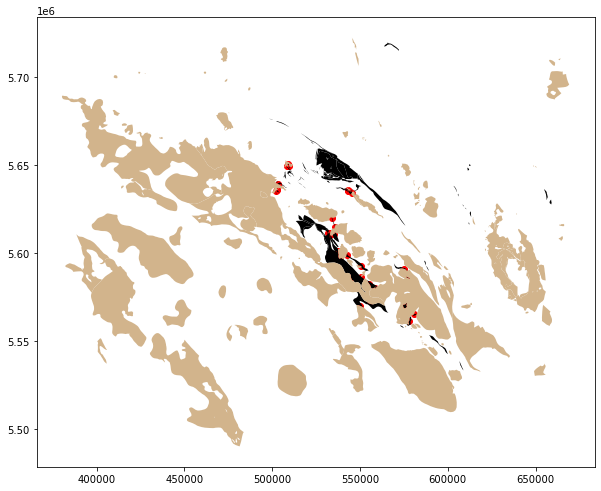

In [292]:
type_a = dfA.copy()
type_b = typeBRocksData.copy()
centroids = dfA.copy().set_geometry("centroids")

ax = centroids.plot(color="red", figsize=(10, 10))
type_a.plot(ax=ax, color="black")
type_b.plot(ax=ax, color="tan")

In [34]:
typeB = bd[bd['rock_type'].str.contains('granodioritic')]
typeB.head(2)

,gid,upid,area_m2,strat_unit,era,period,strat_age,strat_name,gp_suite,fm_lithodm,...,terrane,basin,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org,geometry
14,33925.0,e36913f3,9503497.0,EMRgd,Cenozoic,Paleogene,Eocene,Mission Ridge suite,Mission Ridge suite,None,...,Post Accretionary,None,None,Chilcotin-Bonaparte,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza et al., 1997, Chilcotin-Bonaparte, ...","Schiarizza, 2017, Chicotin-Bonaparte",2018-04-05,British Columbia Geological Survey,"POLYGON ((546785.936 5634543.225, 546791.903 5..."
15,34250.0,6686d9f6,42016632.0,EMRgd,Cenozoic,Paleogene,Eocene,Mission Ridge suite,Mission Ridge suite,None,...,Post Accretionary,None,None,Chilcotin-Bonaparte,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza et al., 1997, Chilcotin-Bonaparte, ...","Schiarizza, 2017, Chicotin-Bonaparte",2018-04-05,British Columbia Geological Survey,"POLYGON ((551602.263 5626737.312, 551566.932 5..."


In [101]:
import copy

typeACopy = copy.deepcopy(typeA)
typeACopy['exterior_coords'] = typeA['geometry'].exterior
typeACopy['exterior_coords']

typeACopy['exterior_coords'] = typeA.apply(lambda row: row.geometry.exterior, axis = 1)
typeACopy['exterior_coords']

17      ((550887.4417813979, 5638245.332573675), (5507...
24      ((531424.1352243299, 5613962.183021259), (5316...
39      ((530406.9298187823, 5614886.453692686), (5304...
50      ((544869.6480692731, 5596786.571985884), (5440...
60      ((517670.47026719624, 5618847.1143065225), (51...
                              ...                        
1302    ((572117.8342096843, 5715942.571344447), (5720...
1332    ((556490.9689679914, 5579696.825060687), (5562...
1338    ((509033.2075789281, 5640733.716352958), (5091...
1558    ((569311.9647012327, 5594130.056570495), (5701...
1583    ((538349.1019821968, 5606250.125797727), (5371...
Name: exterior_coords, Length: 88, dtype: object

(466299.2689440283, 5669863.835678858)

In [121]:
x = (a.coords[0][0] + b.coords[0][0]) / 2
y = (a.coords[0][1] + b.coords[0][1]) / 2
c = Point(x,y)

print(a.coords[0])

print(c.coords[0])

print(b.coords[0])


(466385.7352393744, 5669946.431659935)
(466299.2689440283, 5669863.835678858)
(466212.8026486822, 5669781.23969778)


<AxesSubplot:>

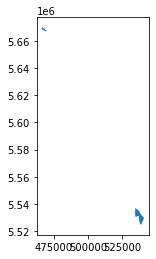

In [73]:
polys = geo[0:2]
polys.plot()

In [41]:
bd['rock_type'].head(40)

0     coarse volcaniclastic and pyroclastic volcanic...
1                 marine sedimentary and volcanic rocks
2                 marine sedimentary and volcanic rocks
3     mudstone, siltstone, shale fine clastic sedime...
4                               basaltic volcanic rocks
5                           undivided sedimentary rocks
6                           undivided sedimentary rocks
7                              andesitic volcanic rocks
8                           undivided sedimentary rocks
9                  feldspar porphyritic intrusive rocks
10                          undivided sedimentary rocks
11                          undivided sedimentary rocks
12                marine sedimentary and volcanic rocks
13                          undivided sedimentary rocks
14                        granodioritic intrusive rocks
15                        granodioritic intrusive rocks
16                marine sedimentary and volcanic rocks
17                                     ultramafi

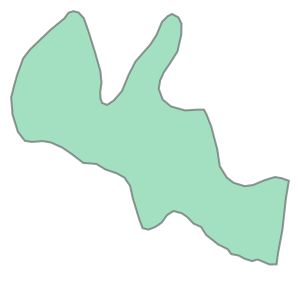

In [48]:
bd['geometry'][0]

In [63]:
print(bd['geometry'][1])

POLYGON ((541326.0118804163 5529535.058946755, 541118.8404639919 5528958.183492733, 540851.0259877077 5528211.981742596, 540527.0006369749 5527499.143046972, 539134.9911005405 5524437.010727834, 539005.7920072802 5524585.394231848, 538857.9943295817 5524755.018027465, 538603.0325393237 5525169.965736751, 538202.9383458507 5526231.996707694, 537910.9802137702 5527226.030030128, 537699.9956158529 5528140.024131241, 537499.0091741275 5529877.980423516, 537466.0343896033 5530629.989633919, 537294.9722048101 5531092.023451111, 537086.0448942863 5531206.97268131, 536817.9923752818 5531155.969206683, 536444.9874679482 5530957.994442357, 535942.0523494366 5530537.998555183, 535543.9634895817 5530312.014996624, 535325.0425619542 5530325.005550823, 535212.051377928 5530379.000992435, 534996.9551343175 5530680.004633782, 534862.0558544642 5531371.005016215, 534753.0561644225 5533029.977703548, 534785.0153045013 5533631.023451384, 534755.0013047422 5534133.968419592, 534893.9374442638 5535478.9853

In [65]:
bd['geometry'][1].bounds

(534753.0561644225, 5524437.010727834, 541326.0118804163, 5537193.965351506)

<AxesSubplot:>

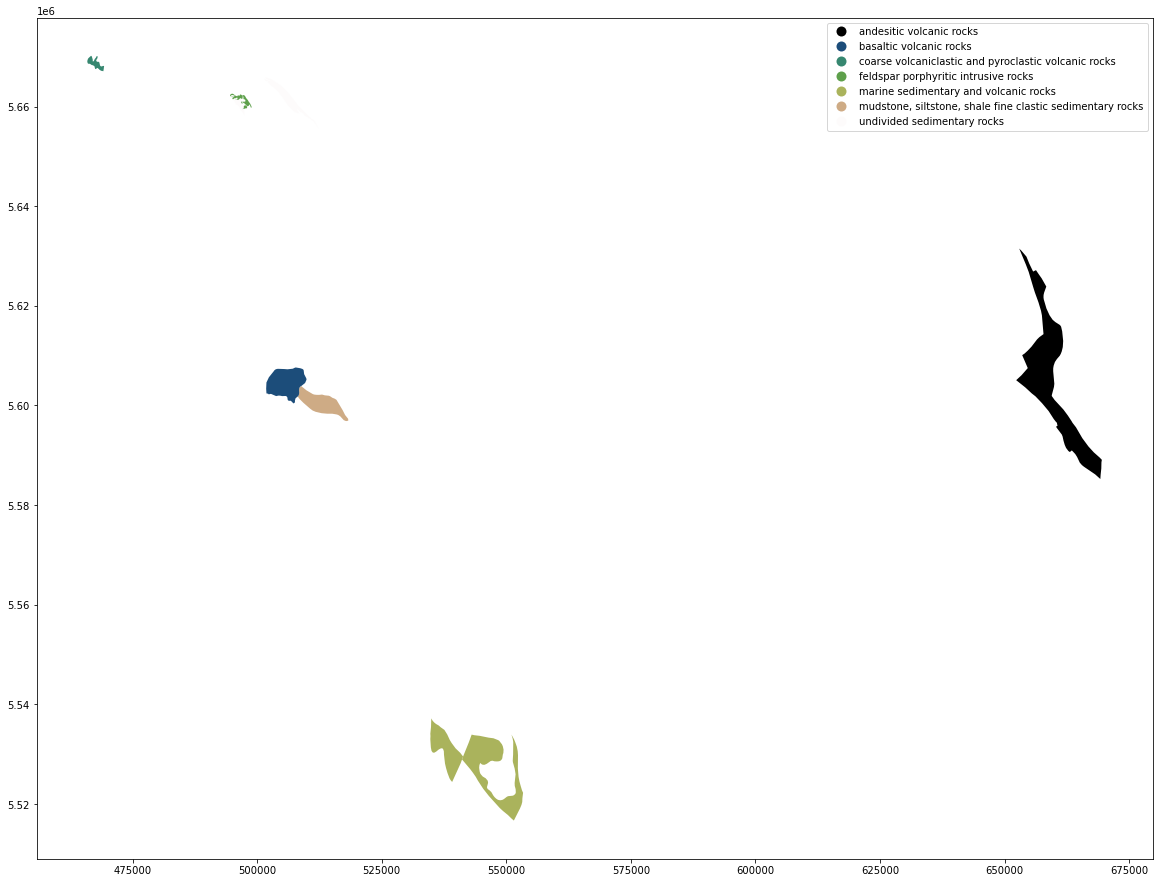

In [60]:
subset = bd[['rock_type', 'geometry']]
subset.head(10).plot(column="rock_type", categorical=True, legend=True, figsize=(20,20), cmap="gist_earth")

In [8]:
bedrock_data.columns

Index(['gid', 'upid', 'area_m2', 'strat_unit', 'era', 'period', 'strat_age',
       'strat_name', 'gp_suite', 'fm_lithodm', 'mem_phase', 'rock_class',
       'rock_type', 'rk_char', 'unit_desc', 'age_max', 'age_min', 'belt',
       'terrane', 'basin', 'basin_age', 'project', 'src_url', 'src_ref_s',
       'map_comp', 'edit_date', 'pub_org', 'geometry'],
      dtype='object')

In [10]:
bedrock_data["area"] = bedrock_data.area
bedrock_data["area"]

0       4.365447e+06
1       3.440510e+07
2       7.443561e+07
3       2.883555e+07
4       3.886702e+07
            ...     
1591    1.443373e+07
1592    1.268831e+06
1593    8.180228e+05
1594    4.715414e+05
1595    1.023430e+07
Name: area, Length: 1596, dtype: float64

In [11]:
bedrock_data["boundary"] = bedrock_data.boundary
bedrock_data["boundary"]

0       LINESTRING (466212.803 5669781.240, 466385.735...
1       LINESTRING (541326.012 5529535.059, 541118.840...
2       LINESTRING (541118.840 5528958.183, 541326.012...
3       LINESTRING (508143.471 5601807.482, 508301.595...
4       LINESTRING (508835.893 5603890.448, 508674.020...
                              ...                        
1591    LINESTRING (476082.704 5549727.241, 475761.952...
1592    LINESTRING (496613.988 5534771.006, 496315.971...
1593    LINESTRING (460878.646 5599077.963, 460582.999...
1594    LINESTRING (640998.944 5566736.997, 641981.448...
1595    LINESTRING (660728.221 5528947.003, 660543.375...
Name: boundary, Length: 1596, dtype: geometry

In [12]:
bedrock_data.head()

,gid,upid,area_m2,strat_unit,era,period,strat_age,strat_name,gp_suite,fm_lithodm,...,basin_age,project,src_url,src_ref_s,map_comp,edit_date,pub_org,geometry,area,boundary
0,33649.0,9c192ffb,4368828.0,uKPCvl,Mesozoic,Cretaceous,Upper Cretaceous,Powell Creek Formation - upper unit,None,Powell Creek Formation,...,None,Chilcotin-Bonaparte,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza et al., 1997, Chilcotin-Bonaparte, ...","Schiarizza, 2017, Chicotin-Bonaparte",2018-04-05,British Columbia Geological Survey,"POLYGON ((466212.803 5669781.240, 466385.735 5...",4.365447e+06,"LINESTRING (466212.803 5669781.240, 466385.735..."
1,26344.0,824df15e,34431394.0,lKGsv,Mesozoic,Cretaceous,Lower Cretaceous,Gambier Group,Gambier Group,None,...,None,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((541326.012 5529535.059, 541118.840 5...",3.440510e+07,"LINESTRING (541326.012 5529535.059, 541118.840..."
2,29100.0,2f4fa4a6,74490974.0,lKGsv,Mesozoic,Cretaceous,Lower Cretaceous,Gambier Group,Gambier Group,None,...,None,Mid-coast,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Bellefontaine et al., 1994, Mid-coast, BCGS, O...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((541118.840 5528958.183, 541326.012 5...",7.443561e+07,"LINESTRING (541118.840 5528958.183, 541326.012..."
3,18121.0,8c3e4237,28858519.0,JKCsf,Mesozoic,Jurassic to Cretaceous,Jurassic to Cretaceous,Cayoosh assemblage?,Cayoosh assemblage?,None,...,None,Okanagan,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza and Church., 1996, Okanagan, BCGS, ...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((508143.471 5601807.482, 508301.595 5...",2.883555e+07,"LINESTRING (508143.471 5601807.482, 508301.595..."
4,18113.0,d7681ec3,38898103.0,Mivb,Cenozoic,Neogene,Miocene,None,None,None,...,None,Okanagan,http://www.em.gov.bc.ca/Mining/Geoscience/Publ...,"Schiarizza and Church., 1996, Okanagan, BCGS, ...","Massey et al., 2005, BC",2018-04-05,British Columbia Geological Survey,"POLYGON ((508835.893 5603890.448, 508674.020 5...",3.886702e+07,"LINESTRING (508835.893 5603890.448, 508674.020..."


In [13]:
bedrock_data['centroid'] = bedrock_data.centroid
bedrock_data['centroid']

0       POINT (467519.125 5668620.659)
1       POINT (537809.457 5530945.228)
2       POINT (547401.682 5526948.667)
3       POINT (512896.955 5600387.545)
4       POINT (505824.327 5604504.766)
                     ...              
1591    POINT (475507.307 5553637.007)
1592    POINT (496599.115 5535366.290)
1593    POINT (460944.448 5599565.705)
1594    POINT (641472.799 5566538.384)
1595    POINT (661374.228 5529951.457)
Name: centroid, Length: 1596, dtype: geometry

<AxesSubplot:>

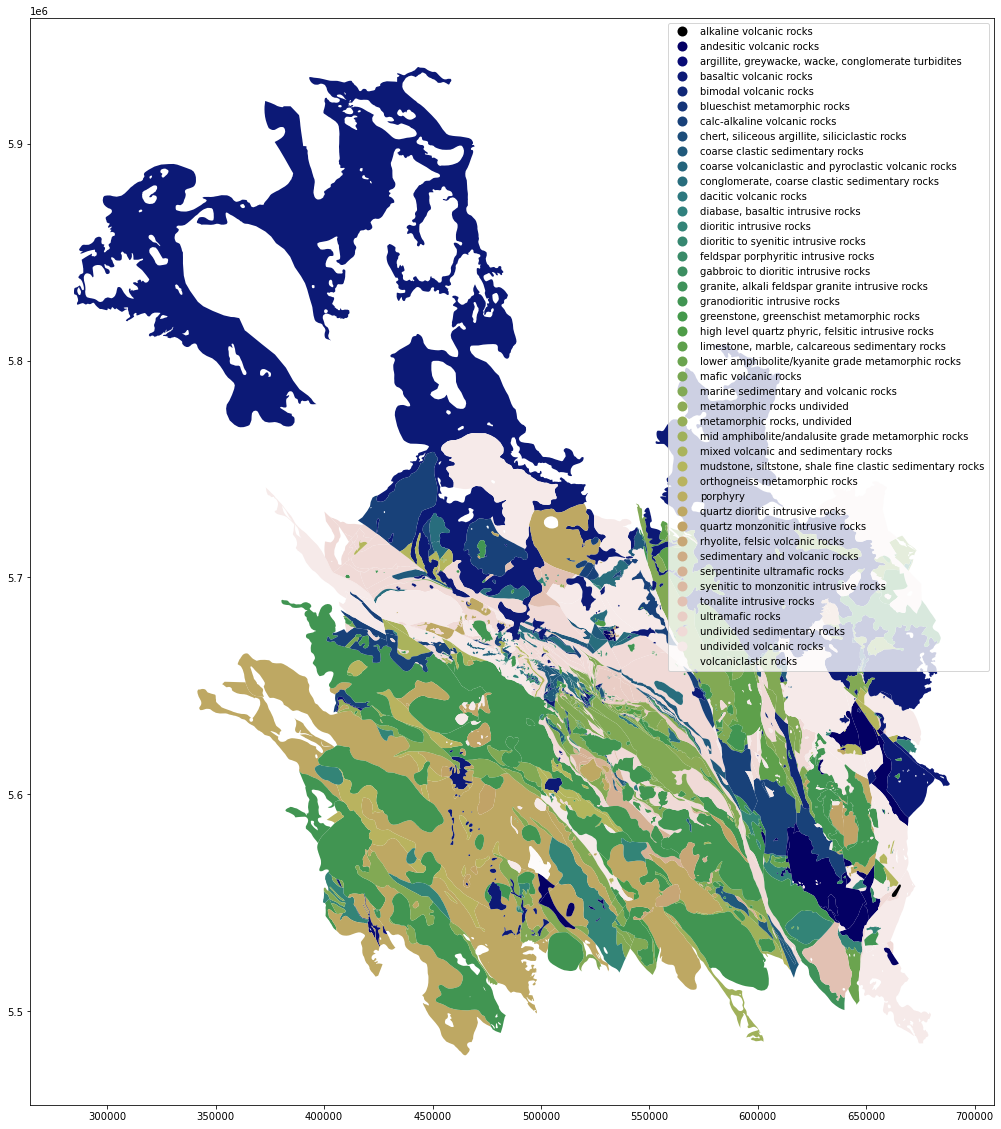

In [42]:
bedrock_data.plot(column="rock_type", categorical=True, legend=True, figsize=(20,20), cmap="gist_earth")